In [1]:
import torch
import math
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

Repeating an [example](https://cooper.readthedocs.io/en/latest/notebooks/plot_dag_learning.html) from [Cooper](cooper.readthedocs.io/): learning a **Directed Acyclic Graph (DAG)** from data.

In [2]:
torch.manual_seed(1)
np.random.seed(1)


def generate_data(
    n: int, d: int, n_causes: int, noise_std: float, device: torch.device
):
    """Generate data from a linear structural equation model with Gaussian noise.
    The

    Args:
        n: number of samples
        d: number of features
        n_causes: number of roots in the graph
        noise_std: standard deviation of the noise
        device: torch.device

    Returns:
        torch.Tensor: Data (X) of shape (n, d)
        torch.Tensor: Graph (A) of shape (d, d)
    """
    assert n_causes <= d

    # --------------------------------------------
    # Generate the adjacency matrix
    # --------------------------------------------

    # Rows are nodes, columns are parents
    A = torch.zeros(d, d, device=device)

    for i in range(n_causes, d):
        # For i=1, the only possible parent is 0
        parents = 0 if i == 1 else torch.randperm(i)[: np.random.randint(1, i)]

        A[i, parents] = 1

    assert torch.trace(torch.linalg.matrix_exp(A)).item() == d, "A is not a DAG"

    # --------------------------------------------
    # Sample data
    # --------------------------------------------

    noise = noise_std * torch.randn(n, d, device=device)
    X = torch.zeros(n, d, device=device)

    for i in range(d):
        parents = torch.nonzero(A[i]).flatten()
        X[:, i] = X[:, parents].sum(dim=1) + noise[:, i]

    # Improve conditioning
    X /= math.sqrt(d)

    return X, A

**Generate training data:**

In [3]:
D = 8
N = 5_000
N_CAUSES = 2
NOISE_STD = 1e-2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate data
X, A_TRUE = generate_data(N, D, N_CAUSES, NOISE_STD, DEVICE)

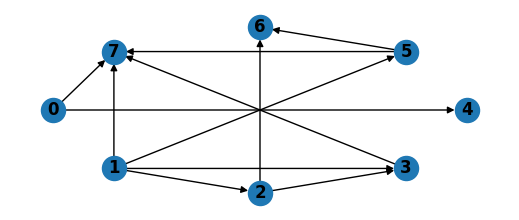

In [4]:
# Visualize the graph
G = nx.DiGraph()

G.add_nodes_from(range(D))
for i in range(D):
    for j in range(D):
        if A_TRUE[i, j] != 0:
            G.add_edge(j, i)

pos = nx.shell_layout(G)

plt.figure(figsize=(5, 2))
nx.draw(G, pos, with_labels=True, font_weight="bold")
plt.show()

***
**Training**:

We disregard sparsity regularization, and solve the following problem:

$\min_{A \in \{0, 1\}^{d \times d}} \left\| X - XA \right\|_F^2,
\quad \text{s.t.} \quad tr(e^A) = d $


In [5]:
from humancompatible.train.dual_optim import ALM
from torch.optim import AdamW

A = torch.nn.Parameter(torch.randn(D, D, device=DEVICE) / math.sqrt(D))

PRIMAL_LR = 1e-2
N_STEPS = 3000
n, d = X.shape

optimizer = AdamW(params=[A])
dual_opt = ALM(m=1)
constraint = lambda A: torch.trace(torch.linalg.matrix_exp(A)) - d

In [6]:
steps, losses, violations, duals = [], [], [], []  # for plotting

for i in range(N_STEPS):
    A.data.fill_diagonal_(0)
    A.data.clamp_(min=0, max=1.0)

    cviol = constraint(A)
    loss = torch.square(torch.linalg.norm(X - X @ A.T, ord="fro"))
    lagrangian = dual_opt.forward_update(loss, cviol.unsqueeze(0))
    lagrangian.backward()
    optimizer.step()
    optimizer.zero_grad()

    if i % 1 == 0:
        steps.append(i)
        losses.append(loss.detach())
        violations.append(cviol.item())
        duals.append(dual_opt.duals.clone().detach())

***
**Results**:

In [7]:
import seaborn as sns

# plotting functions


def plot_adjacency(adjacency, gt_adjacency):
    """Plot side by side: 1)the learned adjacency matrix, 2)the ground truth adj
    matrix and 3)the difference of these matrices
    :param np.ndarray adjacency: learned adjacency matrix
    :param np.ndarray gt_adjacency: ground truth adjacency matrix
    :param str exp_path: path where to save the image
    :param str name: additional suffix to add to the image name
    """
    plt.clf()
    _, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1)

    kwargs = {
        "vmin": 0,
        "vmax": 1,
        "center": 0.5,
        "cmap": "Blues",
        "xticklabels": False,
        "yticklabels": False,
    }
    sns.heatmap(adjacency, ax=ax2, cbar=False, **kwargs)
    sns.heatmap(gt_adjacency, ax=ax3, cbar=False, **kwargs)
    diff = adjacency - gt_adjacency
    diff_norm = abs(diff)
    sns.heatmap(diff_norm, ax=ax1, cbar=False, **kwargs)

    ax1.set_title("Difference (Learned, GT)")
    ax2.set_title("Learned")
    ax3.set_title("Ground truth")

    ax1.set_aspect("equal", adjustable="box")
    ax2.set_aspect("equal", adjustable="box")
    ax3.set_aspect("equal", adjustable="box")

    plt.show()


def plot_progress(steps, losses, violations, duals):
    _, ax = plt.subplots(3, 1, sharex=True)
    ax[0].plot(steps, losses, "tab:blue")
    ax[1].plot(steps, violations, "tab:orange")
    ax[2].plot(steps, duals, "tab:red")

    ax[0].set_ylabel("Loss", labelpad=10, fontsize=10)
    ax[1].set_ylabel("Constraint violation", labelpad=10, fontsize=10)
    ax[2].set_ylabel("Dual parameters", labelpad=10, fontsize=10)

    ax[2].set_xlabel("Steps", fontsize=12)

    plt.show()

<Figure size 640x480 with 0 Axes>

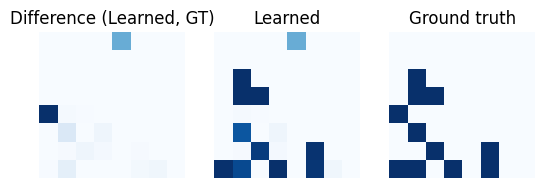

In [8]:
plot_adjacency(A.cpu().detach().numpy(), A_TRUE.cpu().detach().numpy())

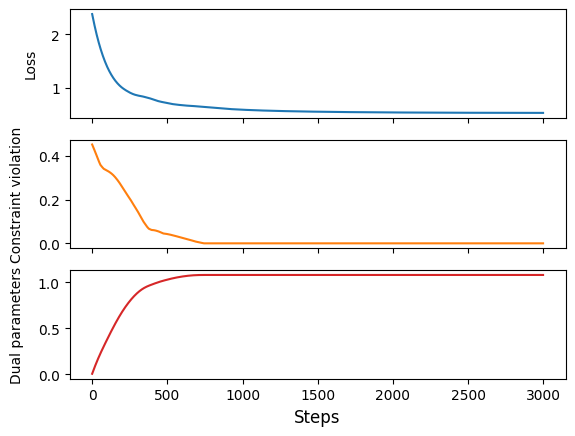

In [9]:
plot_progress(steps, losses, violations, duals)